# Bigram Character Level Language Model
This can servce as an introduction to modern day transformer networks like GPT. Here we have a dataset of most common first names of people in USA. We want to build a model that generates new names based on the names in dataset.

# Part 1: Explore names dataset

In [ ]:
# Pull the dataset
words = open('names.txt','r').read().splitlines()

In [ ]:
# First 10 words in names list
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
# Total words in the dataset
len(words)

32033

In [ ]:

# Smallest word length
min(len(word) for word in words)

2

In [ ]:
# Largest word length
max(len(word) for word in words)

15

In [ ]:
''' Create a mapping of all possible bigram for all words with frequency.
<S> and <E> is added to start and end of each word as special characters'''
b={}
for w in words:
  chars = ['<S>']+list(w)+['<E>']
  for c1, c2 in zip(chars, chars[1:]):
    bigram = (c1,c2)
    b[bigram] = b.get(bigram, 0)+1

In [ ]:
# Looking at the bigram frequency ordered by most frequent
sorted(b.items(), key=lambda x:-x[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

# Part 2: Statistical Modeling of a Bigram Model

In [ ]:
import torch

In [ ]:
# Create a 27x27 tensor
# 28x28 since 26 eng charc and <S> and<E>
N = torch.zeros((27,27), dtype=torch.int32)

In [ ]:
# Create a map of eng alphabet pos to its pos and reverse
# Now . is replaced for <S> and <E> with pos 0
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
# Create a map of all bigram with frequency {(pos of char1, pos char2) -> count} in 2d grid
for w in words:
  chars = ['.']+list(w)+['.']
  for c1, c2 in zip(chars, chars[1:]):
    idx1 = stoi[c1]
    idx2 = stoi[c2]
    N[idx1,idx2] += 1

(-0.5, 26.5, 26.5, -0.5)

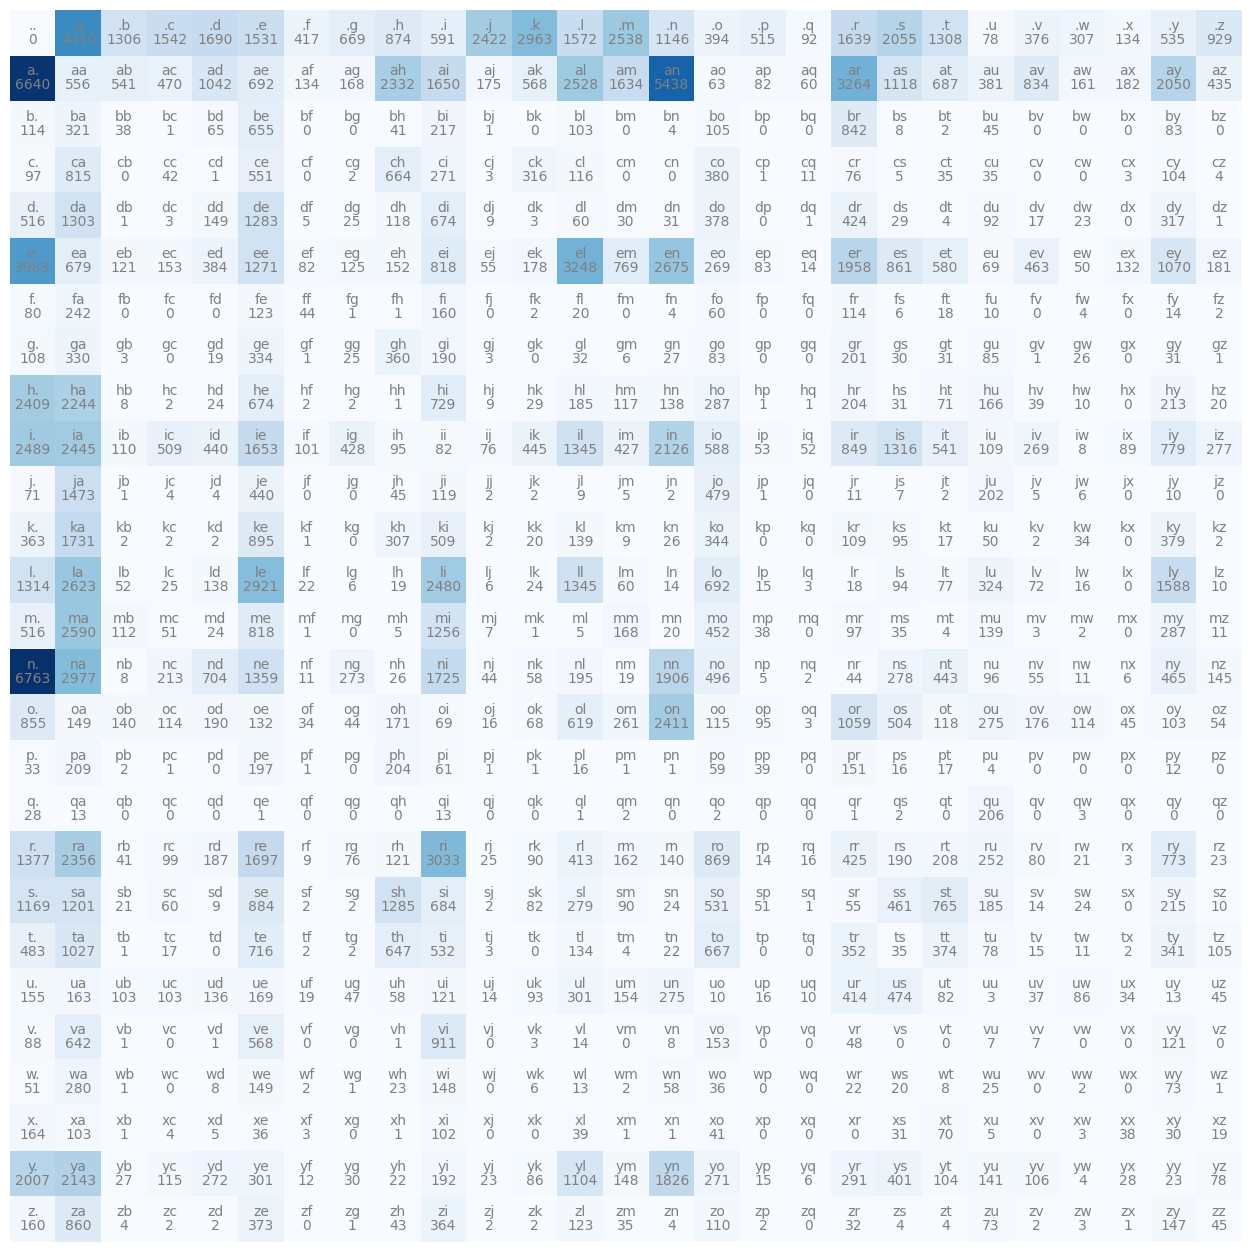

In [ ]:
# Plot the tensor
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    chstr = itos[i]+itos[j]
    plt.text(j,i,chstr, ha="center", va="bottom", color="gray")
    plt.text(j,i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis("off")

In [ ]:
P = (N+1).float() # Convert tensor N to float, we add 1 to all values since 0 values causes error while calculating nll, this smooths out the model
# We convert to a probability distribution for each character on which character is next
P /= P.sum(1, keepdim=True) # Sum tensor along the row axis ansd then divide by each value of the corresponding row, keep dims keeps the each value as its own row element rather than a long vector of sums

In [ ]:
# Generate new words
g = torch.Generator().manual_seed(2147483647) # generator for reproducibility purposes
for i in range(5):
  out=[]
  ix=0 # We always start with . whose position was 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p,  num_samples=1, replacement=True, generator=g).item() # Generate next character based on distributuon we calculated above
    out.append(itos[ix])
    if ix==0: # We stop when we get . character
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [ ]:
# Calculating the errors of the training set or all the distributions we have created so far
# Log likelihood gives us error value which can be from -inf to 0 (more -ve -> more error)
# Negative Log Likelihood inverts that now (more +ve -> more error and 0 is no error) and we take average of that if calculating for as many predictions we do
log_likelihood = 0.0
n = 0
for w in words:
  chs = ["."]+list(w)+["."]
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n+=1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


# Part 3: Deep Learning Modeling of Bigram Model

In [ ]:
# Creating the training set of bigrams where x is the input and y is the prediction
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs) # bigrams first pos (train)
ys = torch.tensor(ys) # bigram second pos (prediction)
num = xs.nelement()

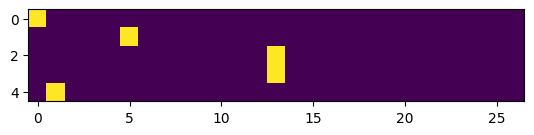

In [ ]:
# Convert all the position in train to one hot encoding
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
# Lets visualize the first 5
plt.imshow(xenc[:5])

In [ ]:
# Define the weight matrix 27*27, here we are creating one hidden layer with no bias, so weight matrix is 27x27 since there are 27 neuron in input layer and 27 in hidden layer
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator = g,  requires_grad=True) # Define initial W with random weights pulled from a normal distribution

In [ ]:
# Running the backprop for 100 iterations
for k in range(100):
  # Forward Pass
  logits = xenc @ W
  counts = logits.exp() # Getting the count as top visualised matrix N
  probs = counts/counts.sum(1, keepdims=True) # We get the probabilities distribution
  loss = -probs[torch.arange(num), ys].log().mean() # Negative log likelihood average, [Train data number, Corresponding y pred prob given by model], mean([-(1*prob(ys1)+1*prob(ys2)+...)]), here also categorical cross entropy
  print(loss.item())

  # Backward Pass
  W.grad = None # For each run we clear the previously created grad, since they were already used for the updates and not needed in the computational graph
  loss.backward()

  # Update Weights
  W.data += -50 * W.grad

3.758953809738159
3.371100425720215
3.1540427207946777
3.020373582839966
2.927711009979248
2.8604023456573486
2.8097288608551025
2.7701022624969482
2.7380728721618652
2.711496591567993
2.6890032291412354
2.6696884632110596
2.65293025970459
2.638277769088745
2.6253879070281982
2.613990545272827
2.60386323928833
2.5948219299316406
2.5867116451263428
2.5794036388397217
2.572789192199707
2.5667762756347656
2.5612878799438477
2.5562586784362793
2.551633596420288
2.547365665435791
2.543415069580078
2.5397486686706543
2.536336660385132
2.5331544876098633
2.5301804542541504
2.5273969173431396
2.5247862339019775
2.522334337234497
2.520028829574585
2.517857789993286
2.515810966491699
2.513878345489502
2.512052059173584
2.5103237628936768
2.5086872577667236
2.5071349143981934
2.5056614875793457
2.5042612552642822
2.5029289722442627
2.5016608238220215
2.5004520416259766
2.4992988109588623
2.498197317123413
2.4971446990966797
2.4961376190185547
2.495173692703247
2.4942493438720703
2.493363380432129

(-0.5, 26.5, 26.5, -0.5)

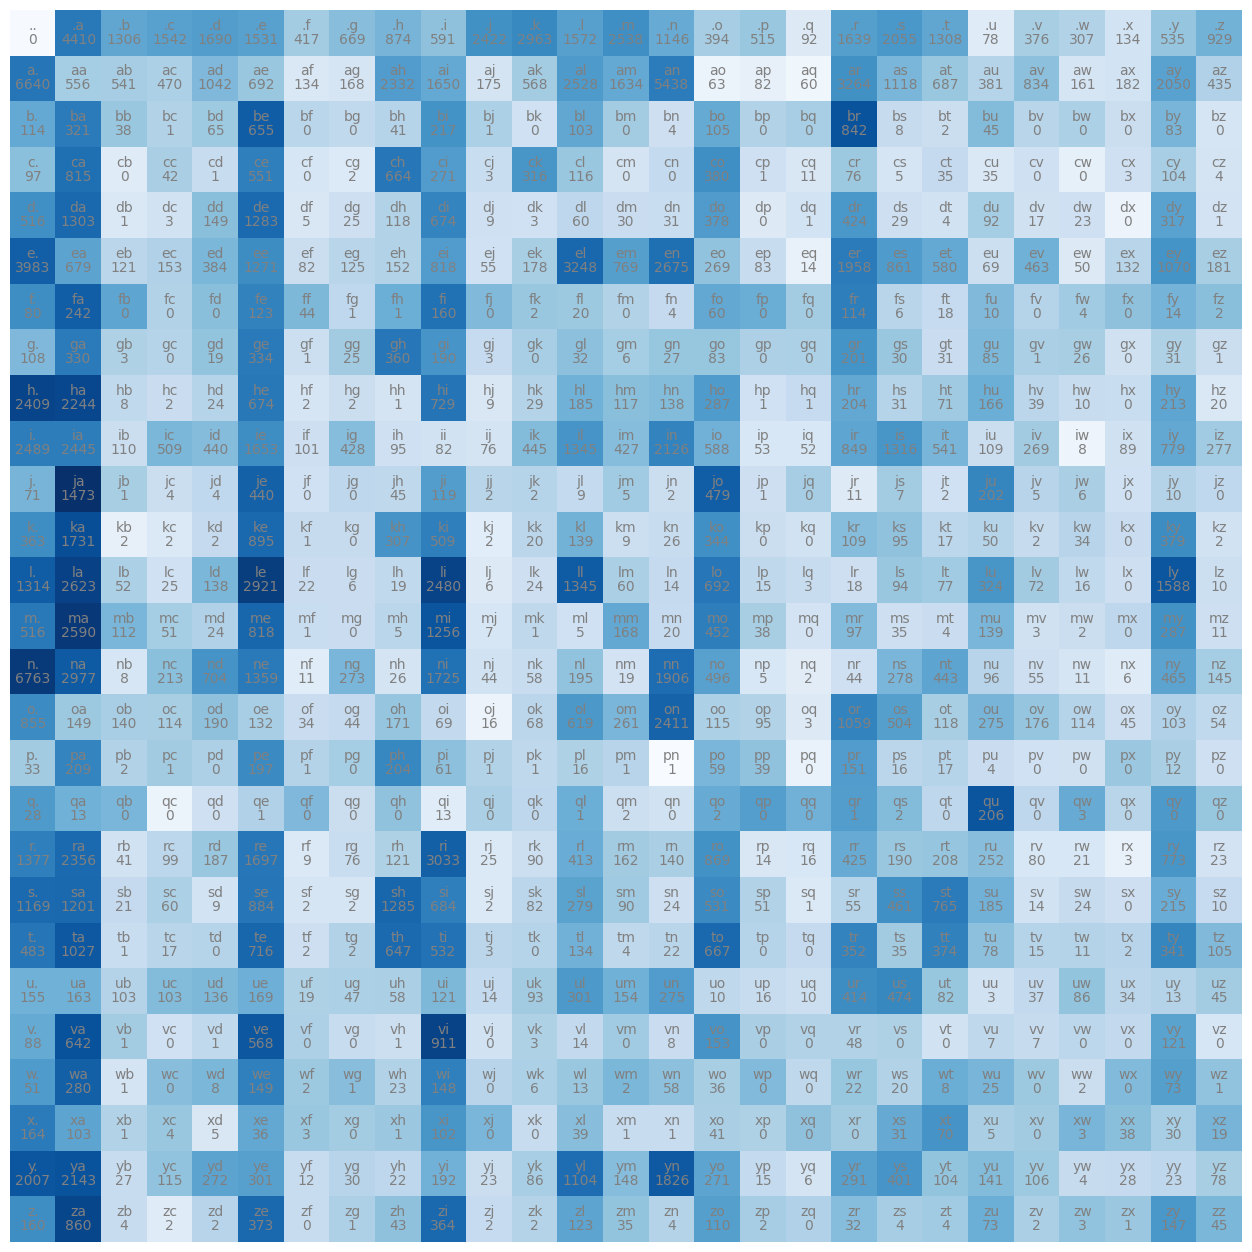

In [ ]:
# Plot the W tensor - We can see that the counts we got here is same as we got by statistical method
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(W.data, cmap='Blues')
for i in range(27):
  for j in range(27):
    chstr = itos[i]+itos[j]
    plt.text(j,i,chstr, ha="center", va="bottom", color="gray")
    plt.text(j,i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis("off")

In [ ]:
# Generate new words from neural net model
g = torch.Generator().manual_seed(2147483647) # generator for reproducibility purposes
for i in range(5):
  out=[]
  ix=0 # We always start with . whose position was 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts/counts.sum(1, keepdims=True)
    ix = torch.multinomial(p,  num_samples=1, replacement=True, generator=g).item() # Generate next character based on distributuon we calculated above
    out.append(itos[ix])
    if ix==0: # We stop when we get . character
      break
  print(''.join(out))

junide.
janasah.
p.
cfay.
a.
